<a href="https://colab.research.google.com/github/MarcosRMG/Bootcamp-Alura-Data-Science/blob/main/Projeto_do_M%C3%B3dulo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


<font size=15>**Análise da série temporal da COVID-19**</font>


---



Autor: Marcos Galvão

[Linkedin](https://br.linkedin.com/in/marcosrmgalvao)

[Github](https://github.com/MarcosRMG)

[Blog Jogando com Dados](https://jogandocomdados.blogspot.com/)


---

# **1 Resumo**

No seguinte relatório foram analisados os dados referente ao número de casos e óbitos da COVID-19, no capítulo 2 foram feitos os tratamentos dos dados e no capítulo 3 a análise da série temporal. As informações exploradas se referem ao comportamento da curva de casos e óbitos, o padrão sazonal e o uso da média móvel para suavização, bem como a autocorrelação da série e verificação da estacionariedade da mesma.
Para previsão de novos casos e óbitos foram utilizados os modelos Autoarima e Prophet, no qual o moelo Prophet retornou um menor erro médio quadrado, com base nos dados consolidados até o dia 24/01/21 o modelo prevê um crescimeto linear para o número de casos e óbitos por covid-19 no Brasil. 
Para uma previsão mais precisa seria necessário considerar outras variáveis para uma análise multivariada, mas tal análise requeriria um conjunto de informações consolidadas, principalmente se fosse considerado a queda no número de casos resultante da vacinação.

## 1.1 Orientações de uso do notebook

1.   Antes de executar qualquer trecho de código execute todas as celulas por meio da função Runtime > Run all disponível no menu superior do Google Colaboratory.

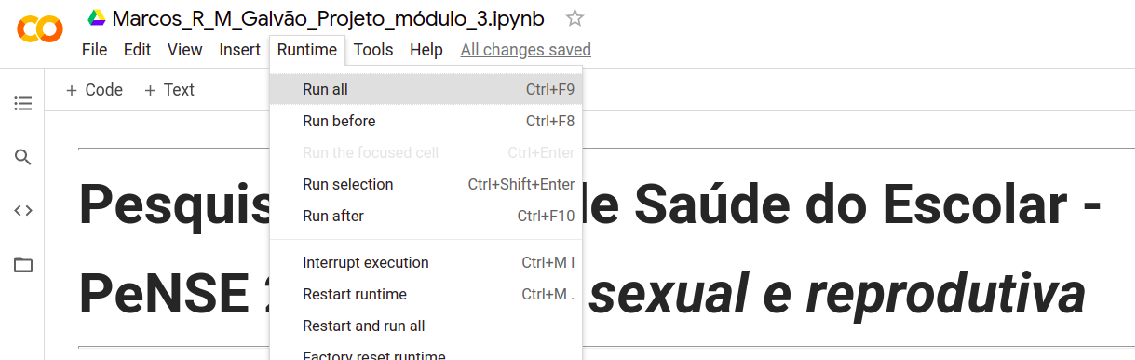

2.   Qualquer alteração nos tópicos de tratamento dos dados (capítulo 2) irá afetar as análises (capítulo 3).

## 1.2 Glossário das principais variáveis 

**covid_19:** Todos os dados disponibilizados pelo site [Coronavírus Brasil](https://covid.saude.gov.br/);

**covid_19_brasil:** Dados disponibilizados pelo site Coronavírus Brasil com filtro na coluna região igual a Brasil;

**previsao_prophet_casos_14:** Previsão dos casos com o modelo Prophet para os próximos 14 dias.

**previsao_prophet_obitos_14:** Previsão do número de óbitos com o modelo Prophet para os próximo 14 dias.

# **2 Tratamento dos dados**

## 2.1 Bibliotecas

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 8.6MB/s 
     |████████████████████████████████| 2.1MB 27.7MB/s 
     |████████████████████████████████| 9.5MB 52.4MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
from fbprophet.plot import plot_plotly, plot_components_plotly

In [ ]:
'''
Alterando configurações padrão de estilo de gráfico do matplotlib e do seaborn
'''
matplotlib.rcParams['figure.figsize'] = [16, 8]
matplotlib.rcParams['font.size'] = 12
sns.set_theme(style='darkgrid', font_scale=1.2)

## 2.2 Funções

### 2.2.1 Gráfico de linhas

In [ ]:
def grafico_linha(x: str, y: str, dados: pd.DataFrame, título: str, x_label: str,
                  y_label: str):
  '''
  Plota o gráfico de linha(s)

  Keywords arguments
  x: Dados do eixo x
  y: Dados do eixo y
  dados: DataFrame contendo os dados dos eixos x e y
  título: Título do gráfico 
  x_label: Descrição do eixo x
  y_label: Descrição do eixo y
  '''
  sns.lineplot(x=x, y=y, data=dados)
  plt.title(título, fontsize=18, loc='left')
  plt.xlabel(x_label, fontsize=12)
  plt.ylabel(y_label, fontsize=12);

### 2.2.2 Média móvel

In [ ]:
def media_movel_7_dias(dados: pd.DataFrame, coluna_calculo: str, coluna_resultado: str):
  '''
  Calcula a média móvel de 7 dias da coluna
  
  Keywords arguments
  dados: Data Frame contendo os dados para cálculo da média móvel
  coluna_calculo: Series pandas contendo os dados para cálculo da média móvel
  coluna_resultado: Nova coluna contendo o resultado da média móvel de 7 dias 
  '''
  dados[coluna_resultado] = round(dados[coluna_calculo].rolling(7, center=True).mean(), 0)
  dados[coluna_resultado].fillna(0, inplace=True)
  dados[coluna_resultado] = dados[coluna_resultado].astype('int32')

### 2.2.3 Gráfico de barras

In [ ]:
def grafico_barras(x: str, y: str, dados: pd.DataFrame, título: str, x_label: str,
                  y_label: str):
  '''
  Plota o gráfico de barra(s)

  Keywords arguments
  x: Dados do eixo x
  y: Dados do eixo y
  dados: DataFrame contendo os dados dos eixos x e y
  título: Título do gráfico 
  x_label: Descrição do eixo x
  y_label: Descrição do eixo y
  '''
  plt.bar(x=x, height=y, data=dados)
  plt.title(título, fontsize=18, loc='left')
  plt.xlabel(x_label, fontsize=12)
  plt.ylabel(y_label, fontsize=12);

### 2.2.4 Personalizar o gráfico com StrMethodFormatter

In [ ]:
def personaliza_grafico(ax, título: str, x_label: str, y_label: str):
  '''
  Adiciona informações descritivas ao gráfico

  Keywords arguments
  título: Título do gráfico 
  x_label: Descrição do eixo x
  y_label: Descrição do eixo y
  '''
  plt.title(título, fontsize=18, loc='left')
  plt.xlabel(x_label, fontsize=12)
  plt.ylabel(y_label, fontsize=12)
  ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'));

### 2.2.5 Personaliza o gráfico sem StrMethodFormatter

In [ ]:
def personaliza_grafico_simples(título: str, x_label: str, y_label: str):
  '''
  Adiciona informações descritivas ao gráfico

  Keywords arguments
  título: Título do gráfico 
  x_label: Descrição do eixo x
  y_label: Descrição do eixo y
  '''
  plt.title(título, fontsize=18, loc='left')
  plt.xlabel(x_label, fontsize=14)
  plt.ylabel(y_label, fontsize=14);

## 2.3 Leitura dos dados

### 2.3.1 COVID-19

In [ ]:
fonte_covid = 'https://bitbucket.org/MarcosRMG/bootcamp-alura-data-science/raw/fb5ea47f785cc10d623031251793d460dc2ea386/dados/HIST_PAINEL_COVIDBR_24jan2021.csv'

covid_19 = pd.read_csv(fonte_covid, encoding='ISO-8859-1', sep=';')

In [ ]:
covid_19.head(3)

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125.0,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN,NaN


In [ ]:
covid_19.tail(3)

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
1709043,Centro-Oeste,DF,BrasÃ­lia,53,530010.0,53001.0,DISTRITO FEDERAL,2021-01-22,3,3015268.0,268394,1054,4460,8,NaN,NaN,1.0
1709044,Centro-Oeste,DF,BrasÃ­lia,53,530010.0,53001.0,DISTRITO FEDERAL,2021-01-23,3,3015268.0,269350,956,4468,8,NaN,NaN,1.0
1709045,Centro-Oeste,DF,BrasÃ­lia,53,530010.0,53001.0,DISTRITO FEDERAL,2021-01-24,4,3015268.0,270171,821,4476,8,NaN,NaN,1.0


In [ ]:
covid_19.shape

(1709046, 17)

## 2.4 Covid 19 no Brasil

In [ ]:
covid_19.columns

Index(['regiao', 'estado', 'municipio', 'coduf', 'codmun', 'codRegiaoSaude',
       'nomeRegiaoSaude', 'data', 'semanaEpi', 'populacaoTCU2019',
       'casosAcumulado', 'casosNovos', 'obitosAcumulado', 'obitosNovos',
       'Recuperadosnovos', 'emAcompanhamentoNovos', 'interior/metropolitana'],
      dtype='object')

In [ ]:
# Filtragem dos dados em âmbito nacional e colunas de interesse
covid_19_brasil = covid_19.query('regiao == "Brasil"')[['data', 'semanaEpi', 
                                                       'populacaoTCU2019',
                                                       'casosAcumulado', 
                                                       'casosNovos', 
                                                       'obitosAcumulado', 
                                                       'obitosNovos',
                                                       'Recuperadosnovos', 
                                                       'emAcompanhamentoNovos', 
                                                       'interior/metropolitana']]

In [ ]:
covid_19_brasil.head(3)

,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,2020-02-25,9,210147125.0,0,0,0,0,NaN,NaN,NaN
1,2020-02-26,9,210147125.0,1,1,0,0,NaN,NaN,NaN
2,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN,NaN


In [ ]:
covid_19_brasil.tail(3)

,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
334,2021-01-22,3,210147125.0,8753920,56552,215243,1096,7594771.0,943906.0,NaN
335,2021-01-23,3,210147125.0,8816254,62334,216445,1202,7628438.0,971371.0,NaN
336,2021-01-24,4,210147125.0,8844577,28323,217037,592,7653770.0,973770.0,NaN


In [ ]:
#Checando a consistência dos dados
covid_19_brasil['obitosNovos'].sum()

217037

In [ ]:
covid_19_brasil.dtypes

data                       object
semanaEpi                   int64
populacaoTCU2019          float64
casosAcumulado              int64
casosNovos                  int64
obitosAcumulado             int64
obitosNovos                 int64
Recuperadosnovos          float64
emAcompanhamentoNovos     float64
interior/metropolitana    float64
dtype: object

In [ ]:
# Alterando a coluna data para o tipo data 
covid_19_brasil['data'] = pd.to_datetime(covid_19_brasil['data'])

### 2.4.1 Datas duplicadas

In [ ]:
np.array(covid_19_brasil['data'].duplicated())

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

Há duas datas duplicadas no final do array, o próximo passo é saber qual a data que não contem dados.

In [ ]:
covid_19_brasil[['data', 'casosNovos', 'obitosNovos']][303:]

,data,casosNovos,obitosNovos
303,2020-12-24,60076,786
304,2020-12-24,0,0
305,2020-12-25,22967,482
306,2020-12-26,17246,307
307,2020-12-27,18479,344
308,2020-12-28,20548,431
309,2020-12-29,58718,1111
310,2020-12-30,55649,1194
311,2020-12-31,56773,1074
312,2021-01-01,24605,462


As data duplicadas são os dias 24/12/2020 e 13/01/2021, onde a segunda data não contém informação.
A primeira data é a que deve ser mantida.

In [ ]:
covid_19_brasil.drop_duplicates('data', inplace=True)

In [ ]:
covid_19_brasil[['data', 'casosNovos', 'obitosNovos']][303:]

,data,casosNovos,obitosNovos
303,2020-12-24,60076,786
305,2020-12-25,22967,482
306,2020-12-26,17246,307
307,2020-12-27,18479,344
308,2020-12-28,20548,431
309,2020-12-29,58718,1111
310,2020-12-30,55649,1194
311,2020-12-31,56773,1074
312,2021-01-01,24605,462
313,2021-01-02,15827,314


### 2.4.2 Médias móveis

In [ ]:
covid_19_brasil.set_index('data', inplace=True, verify_integrity=True)

In [ ]:
media_movel_7_dias(covid_19_brasil, 'casosNovos', 
                   'casos_novos_media_movel_7_dias')

In [ ]:
media_movel_7_dias(covid_19_brasil, 'obitosNovos', 
                   'obitos_novos_media_movel_7_dias')

### 2.4.3 Aceleração

In [ ]:
covid_19_brasil['casos_aceleracao'] = covid_19_brasil['casosNovos'].diff()
covid_19_brasil['obitos_aceleracao'] = covid_19_brasil['obitosNovos'].diff()

### 2.4.4 Dias da semana

In [ ]:
covid_19_brasil['dia_semana'] = covid_19_brasil.index.day_name()

In [ ]:
dias_traduzidos = {
    'Monday': 'Segunda',
    'Tuesday': 'Terça',
    'Wednesday': 'Quarta',
    'Thursday': 'Quinta',
    'Friday': 'Sexta',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

covid_19_brasil['dia_semana'] = covid_19_brasil['dia_semana'].map(dias_traduzidos)

In [ ]:
dia_semana_casos_obitos = covid_19_brasil.groupby('dia_semana')['casosNovos',
                                                                'obitosNovos'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
dia_semana_casos_obitos = dia_semana_casos_obitos.reindex(['Domingo', 'Segunda', 
                                                           'Terça', 'Quarta', 
                                                           'Quinta', 'Sexta', 
                                                           'Sábado'])

In [ ]:
dia_semana_casos_obitos

,casosNovos,obitosNovos
dia_semana,,
Domingo,15370.625000,357.854167
Segunda,14467.659574,397.191489
Terça,29351.166667,786.625000
Quarta,33495.833333,821.562500
Quinta,33299.000000,812.875000
Sexta,30529.937500,705.062500
Sábado,28049.208333,648.708333


# **3 Análise dos dados**

## 3.1 Análise exploratória em âmbito Nacional

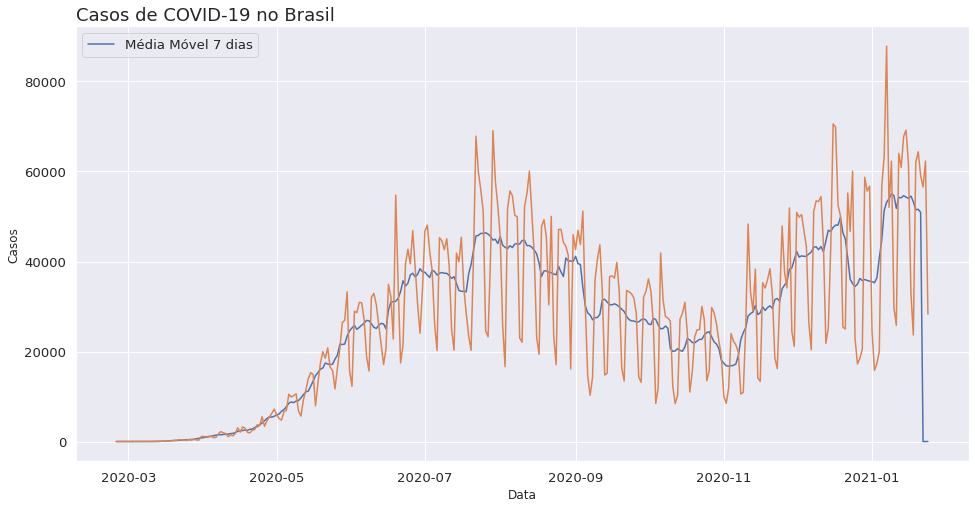

In [ ]:
sns.lineplot(x=covid_19_brasil.index, y='casos_novos_media_movel_7_dias', 
             data=covid_19_brasil,
             label='Média Móvel 7 dias')
grafico_linha(covid_19_brasil.index, 'casosNovos', covid_19_brasil, 
              'Casos de COVID-19 no Brasil', 'Data', 'Casos')
plt.legend();

O número de casos alcançou um pico entre os meses de julho e agosto de 2020, seguido de uma queda até o mês de novembro, retomando uma tendência de crescimento desse mês em diante.

Um dos possíveis motivos para a retomada após o mês de novembro foram as aglomerações causadas pelas datas comemorativas de fim de ano.

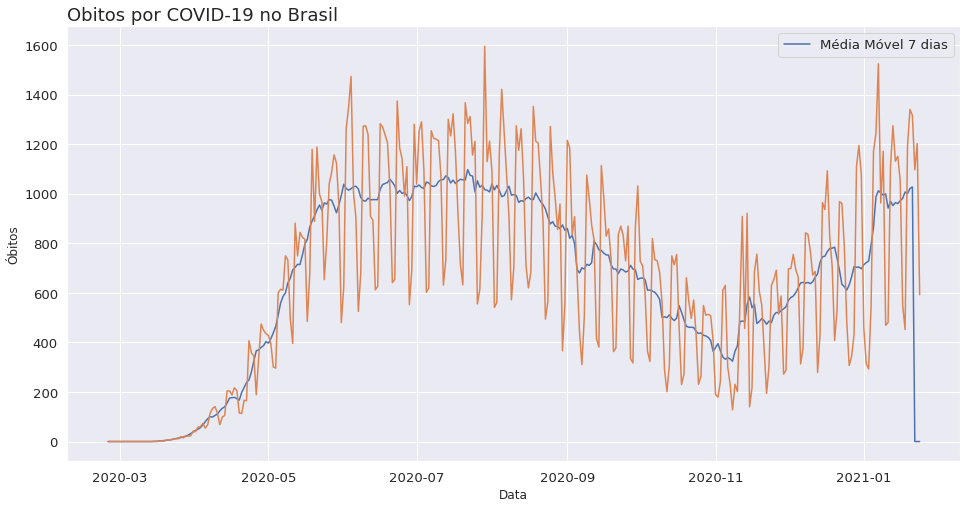

In [ ]:
sns.lineplot(x=covid_19_brasil.index, y='obitos_novos_media_movel_7_dias', 
             data=covid_19_brasil, label='Média Móvel 7 dias')
grafico_linha(covid_19_brasil.index, 'obitosNovos', covid_19_brasil, 
              'Obitos por COVID-19 no Brasil', 'Data', 'Óbitos')
plt.legend();

O número de mortos por COVID-19 alcançou uma média de pouco mais de 1.000 mortes entre os mêses de junho e agosto, seguido de uma queda até o mês de novembro, após esse mês se observa uma tendência de crescimento, alcançando a média de 1.000 mortes em janeiro de 2021.

### 3.1.1 Curva de crescimento COVID-19

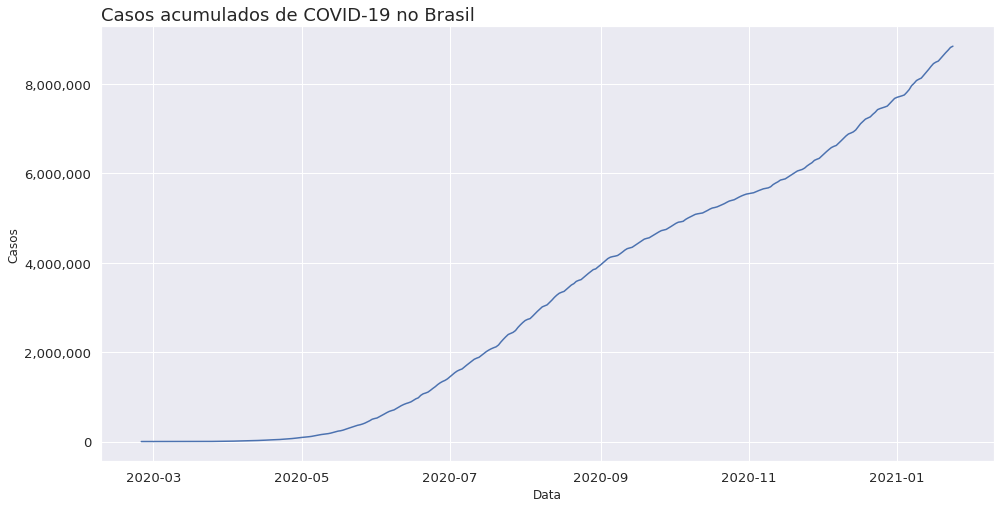

In [ ]:
ax = sns.lineplot(x=covid_19_brasil.index, y='casosAcumulado', 
                  data=covid_19_brasil)
personaliza_grafico(ax, 'Casos acumulados de COVID-19 no Brasil', 'Data', 
                    'Casos')

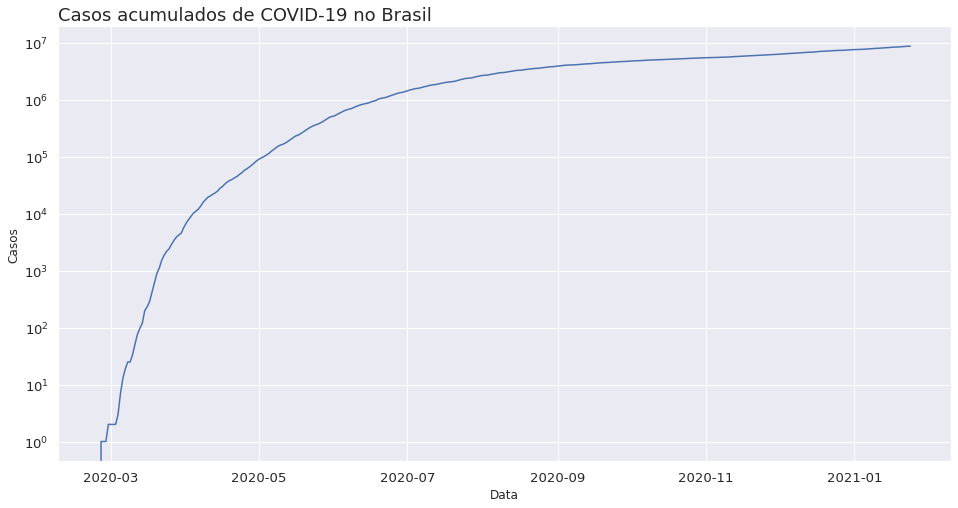

In [ ]:
grafico_linha(covid_19_brasil.index, 'casosAcumulado', covid_19_brasil, 
              'Casos acumulados de COVID-19 no Brasil', 'Data', 'Casos')
plt.yscale('log')

Em escala logarítimica é possível observar o crescimento exponencial do número de casos acumulados, que ainda não demostra queda ou estabilização.

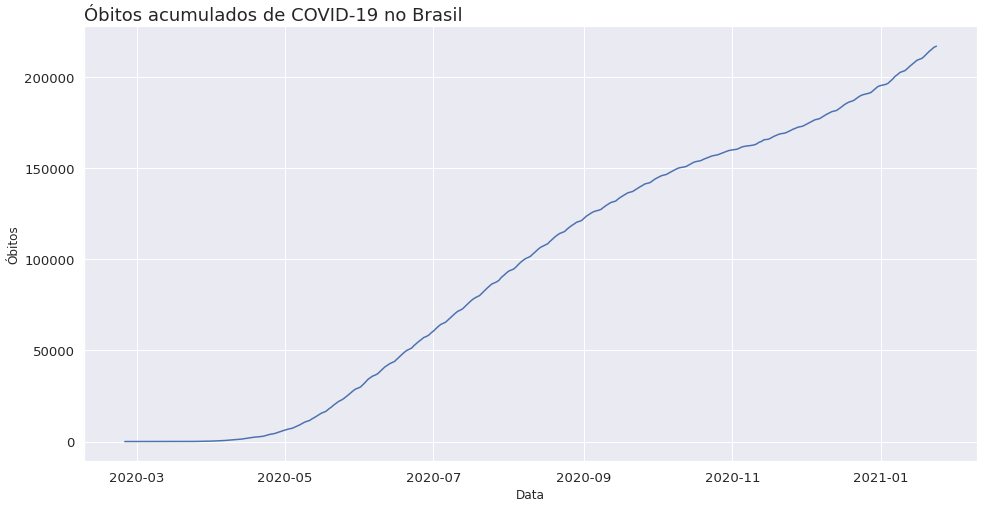

In [ ]:
grafico_linha(covid_19_brasil.index, 'obitosAcumulado', covid_19_brasil, 
              'Óbitos acumulados de COVID-19 no Brasil', 'Data', 'Óbitos')

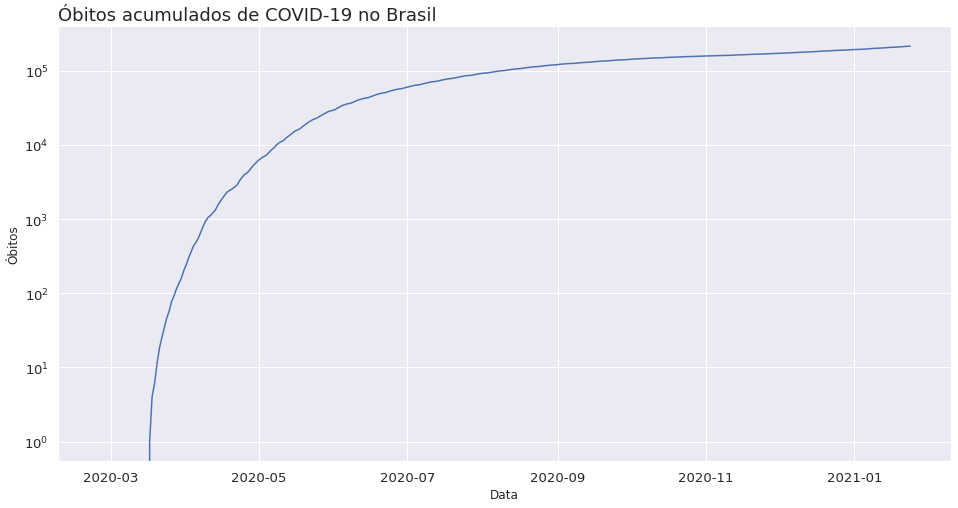

In [ ]:
grafico_linha(covid_19_brasil.index, 'obitosAcumulado', covid_19_brasil, 
              'Óbitos acumulados de COVID-19 no Brasil', 'Data', 'Óbitos')
plt.yscale('log')

A mesma característica de crescimento exponencial se observa no número de óbitos acumulados.

### 3.1.2 Aceleração do número de casos e óbitos

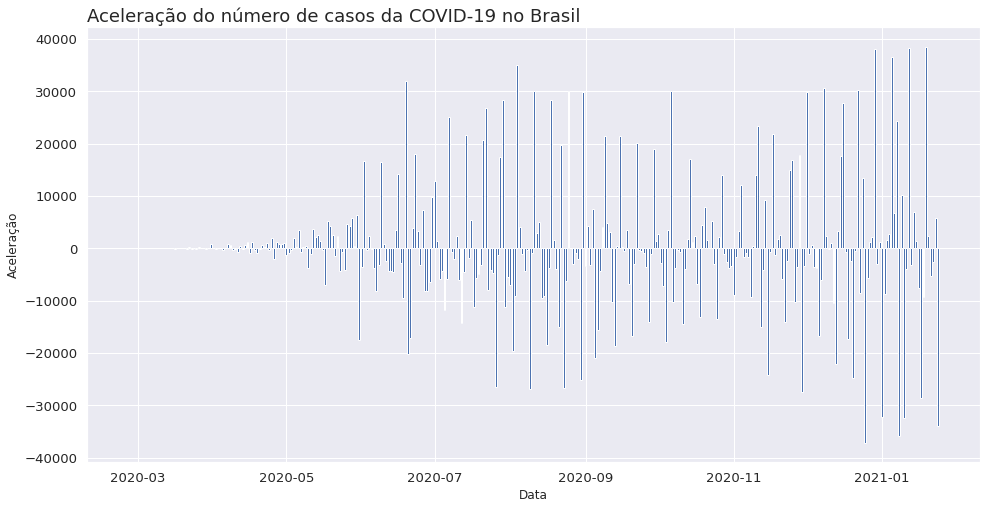

In [ ]:
grafico_barras(covid_19_brasil.index, 'casos_aceleracao', covid_19_brasil,
              'Aceleração do número de casos da COVID-19 no Brasil',
              'Data', 'Aceleração')

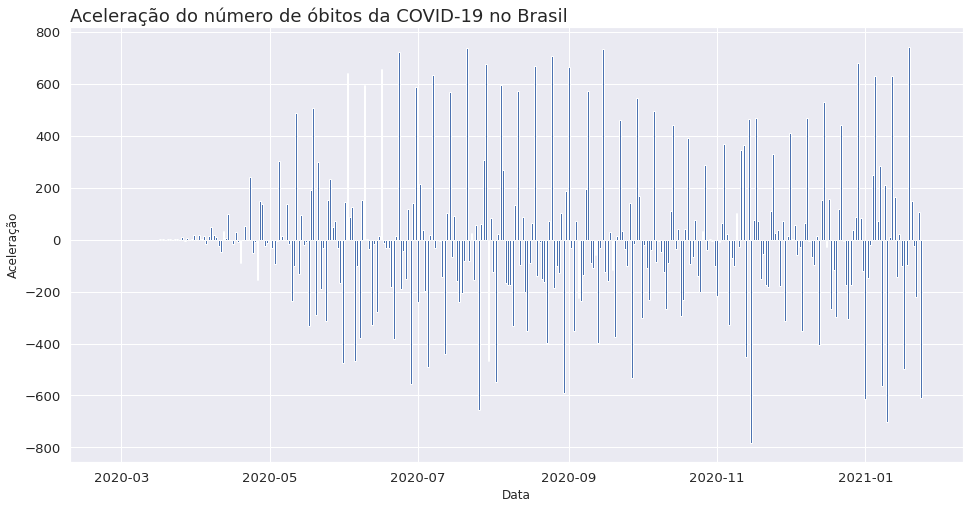

In [ ]:
grafico_barras(covid_19_brasil.index, 'obitos_aceleracao', covid_19_brasil,
              'Aceleração do número de óbitos da COVID-19 no Brasil',
              'Data', 'Aceleração')

Por meio do gráfico de aceleração é possível perceber que tanto para o número de casos quanto para o número de óbitos há um padrão de aceleração e desaceleração, isto se dá pelo padrão de como os dados são reportados, onde nos finais de semana os hospitais e clinicas em regime de plantão não tem como prioridade reportar os casos, gerando um acúmulo para o meio da semana, por isso há essa sazonalidade semanal, o que justifica a utilização de médias móveis semanais para análise dos casos e óbitos da COVID-19.

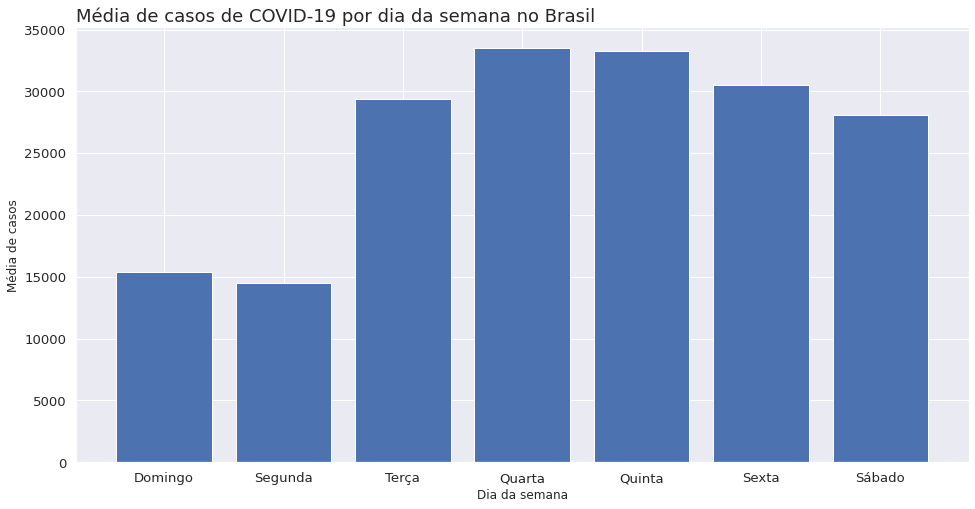

In [ ]:
grafico_barras(dia_semana_casos_obitos.index, 'casosNovos', 
               dia_semana_casos_obitos, 
               'Média de casos de COVID-19 por dia da semana no Brasil',
               'Dia da semana', 'Média de casos')

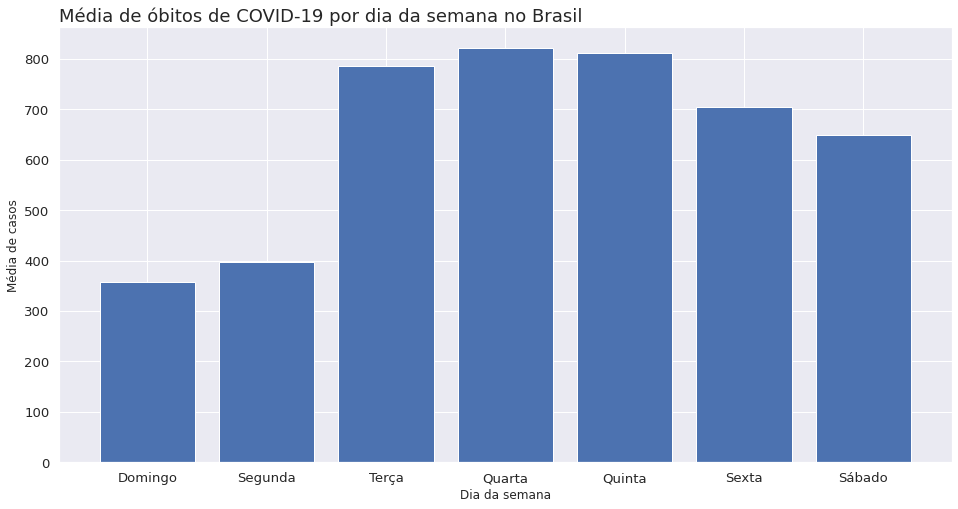

In [ ]:
grafico_barras(dia_semana_casos_obitos.index, 'obitosNovos', 
               dia_semana_casos_obitos, 
               'Média de óbitos de COVID-19 por dia da semana no Brasil',
               'Dia da semana', 'Média de casos')

Os dias de meio de semana possuem a maior média de casos e óbitos, resultante pela diminuição das notificações nos dias de final e início de semana.

### 3.1.3 Média móvel

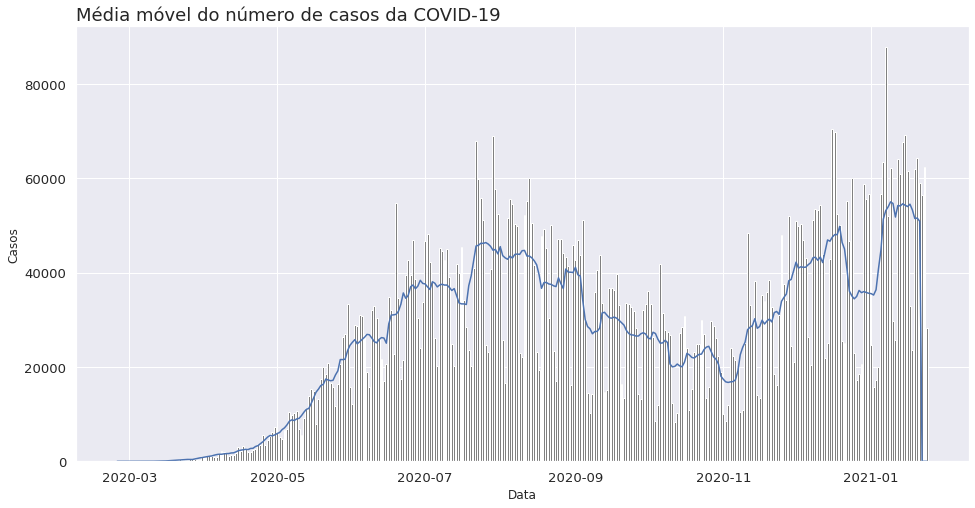

In [ ]:
plt.bar(covid_19_brasil.index, covid_19_brasil['casosNovos'], color='grey')
grafico_linha(covid_19_brasil.index, 'casos_novos_media_movel_7_dias', 
              covid_19_brasil, 'Média móvel do número de casos da COVID-19',
              'Data', 'Casos')

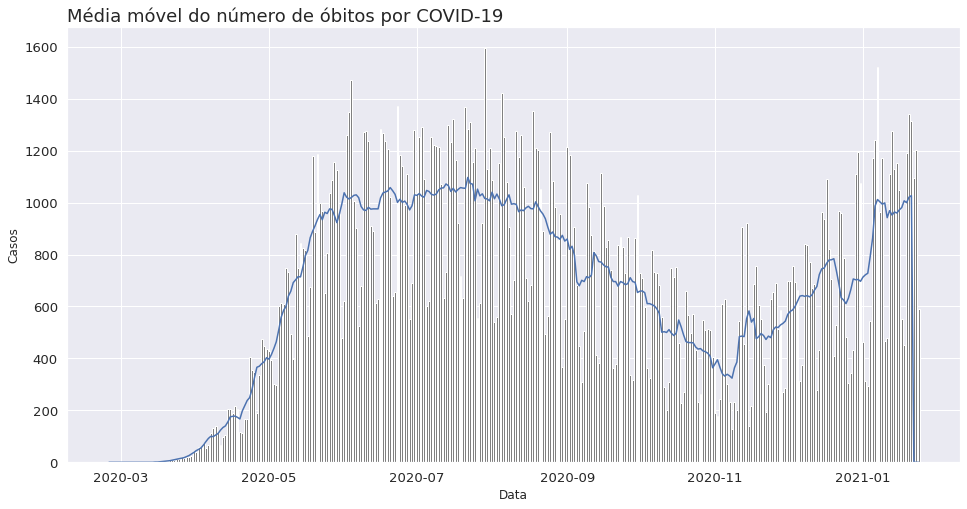

In [ ]:
plt.bar(covid_19_brasil.index, covid_19_brasil['obitosNovos'], color='grey')
grafico_linha(covid_19_brasil.index, 'obitos_novos_media_movel_7_dias', 
              covid_19_brasil, 'Média móvel do número de óbitos por COVID-19',
              'Data', 'Casos')

A média móvel suaviza a séria proporcionando uma visão mais assertiva referente ao comportamento da pandemia no país. Sete dias é utilizado por conta do menor número de notificações nos finais de semana.

### 3.1.4 Decomposição da série temporal

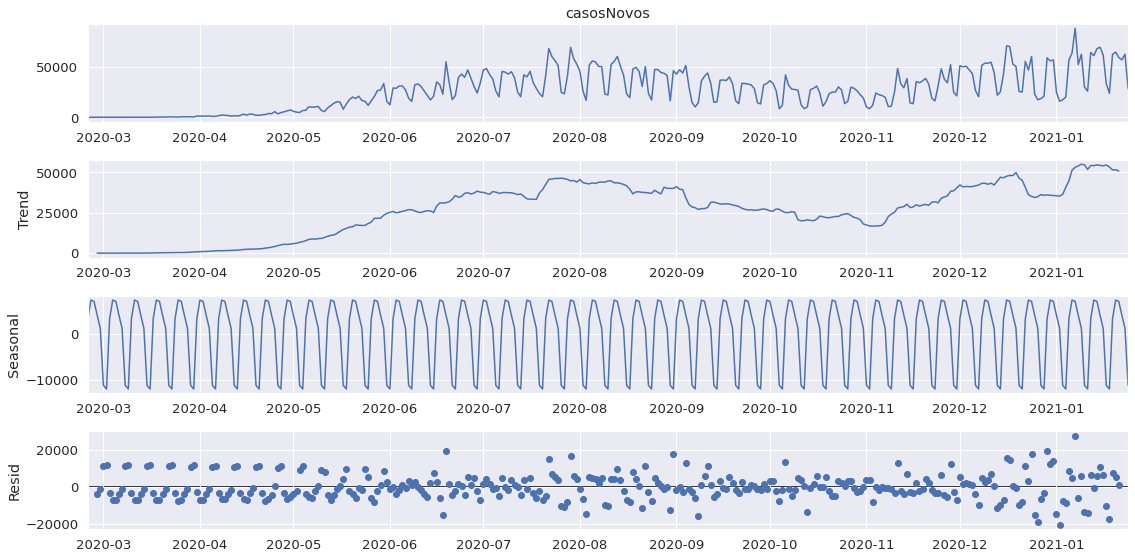

In [ ]:
seasonal_decompose(x=covid_19_brasil['casosNovos']).plot();

Por meio da decomposição fica mais claro tanto a tendência de crescimnto do número de casos no segundo gráfico quanto a sazonalidade provocada pelas variações de queda das notificações nos finais de semana seguida de alta no meio da semana.

### 3.1.5 Autocorelação da série temporal

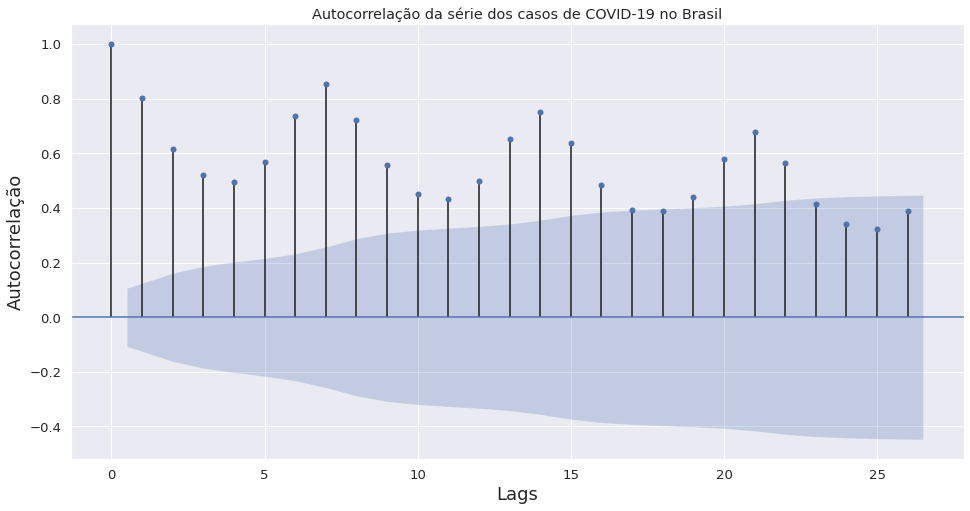

In [ ]:
ax = plot_acf(covid_19_brasil['casosNovos'], 
              title='Autocorrelação da série dos casos de COVID-19 no Brasil')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Autocorrelação', fontsize=18);

Percebe se alguma correlação positiva no sétimo e décimo quarto lag, isso pelo padrão sazonal já observado.

A queda gradual após o primeiro lag caracteriza o modelo de média condicional ARMA (modelo autoregressivo e por média móvel).

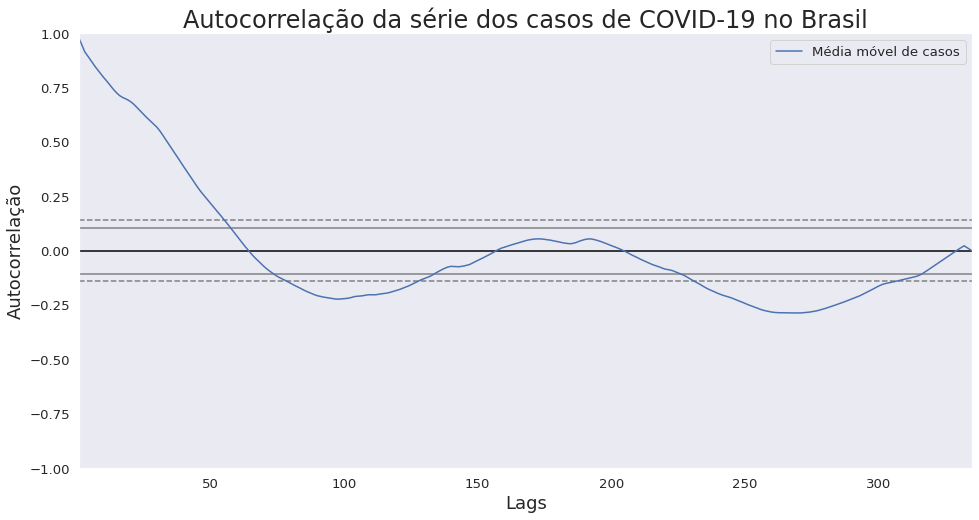

In [ ]:
autocorrelation_plot(covid_19_brasil['casos_novos_media_movel_7_dias'],
                     label='Média móvel de casos')
plt.title('Autocorrelação da série dos casos de COVID-19 no Brasil', 
          fontsize=24)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Autocorrelação', fontsize=18);

Com o uso de média móvel a autocorrelação positiva exste nos primeiros lags, a inexistência de correlação nos demais se dá pela caracterísca exponencial do número de casos.

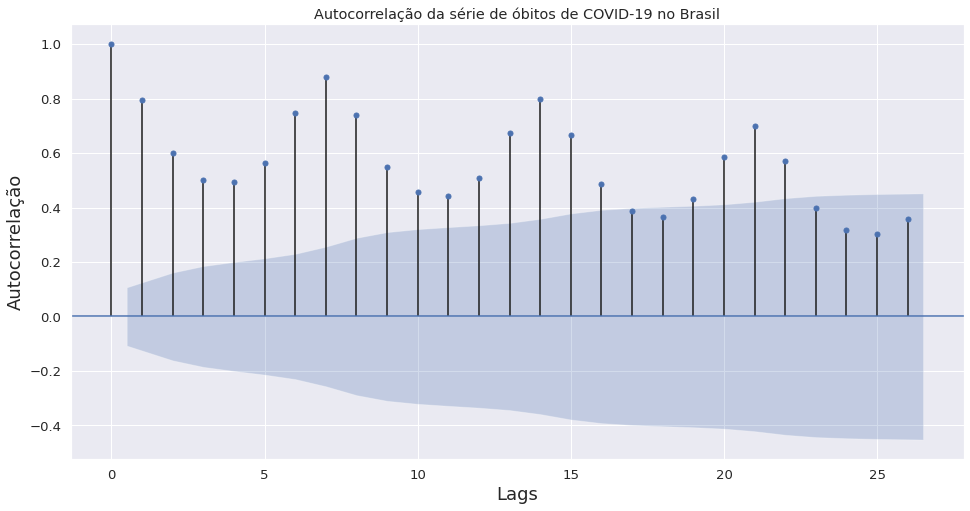

In [ ]:
ax = plot_acf(covid_19_brasil['obitosNovos'], 
              title='Autocorrelação da série de óbitos de COVID-19 no Brasil')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Autocorrelação', fontsize=18);

Mesmo comportamento observado na série de casos.

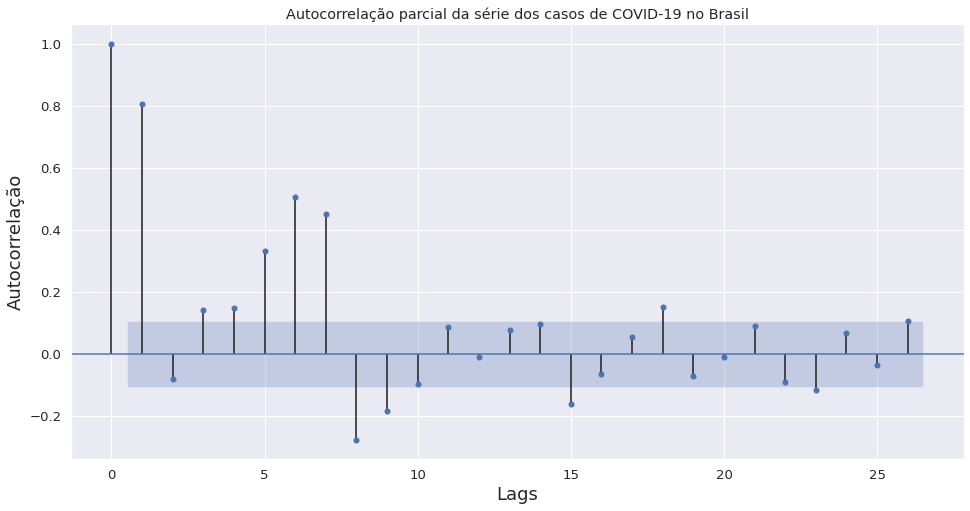

In [ ]:
plot_pacf(covid_19_brasil['casosNovos'],
          title='Autocorrelação parcial da série dos casos de COVID-19 no Brasil')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Autocorrelação', fontsize=18);

A queda brusca após o segundo lag caracteriza o modelo de média condicional como autoregressivo.

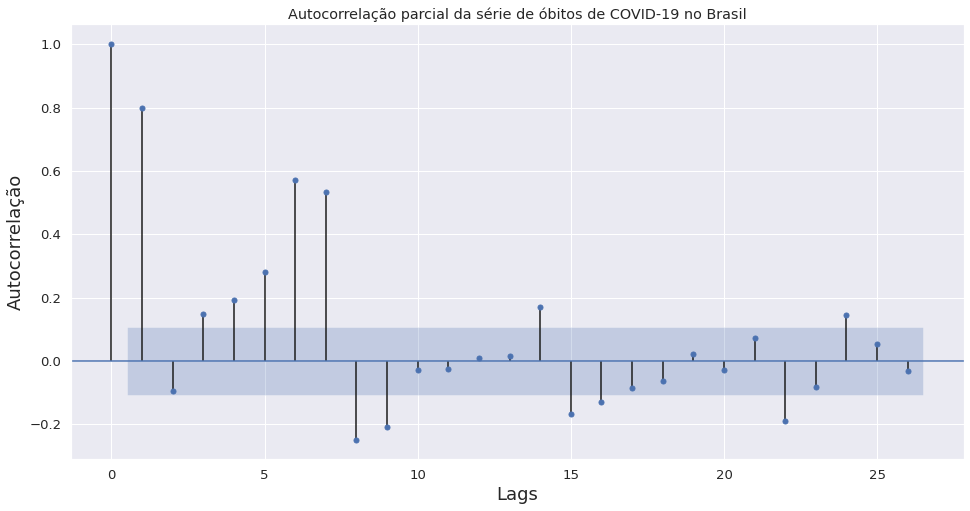

In [ ]:
plot_pacf(covid_19_brasil['obitosNovos'],
          title='Autocorrelação parcial da série de óbitos de COVID-19 no Brasil')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Autocorrelação', fontsize=18);

Comportamento similar à série de casos.

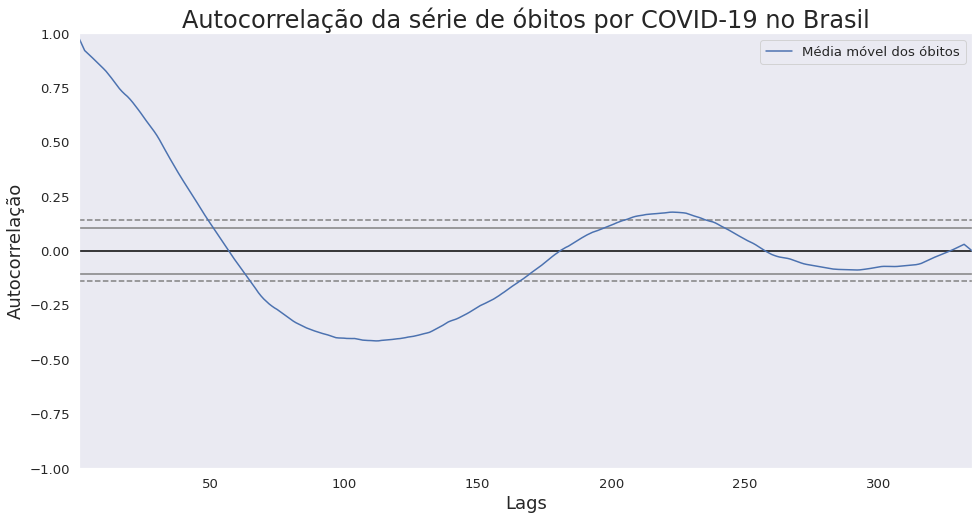

In [ ]:
autocorrelation_plot(covid_19_brasil['obitos_novos_media_movel_7_dias'],
                     label='Média móvel dos óbitos')
plt.title('Autocorrelação da série de óbitos por COVID-19 no Brasil', 
          fontsize=24)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Autocorrelação', fontsize=18);

Comportamento similar ao observado a autocorrelação do número de casos.

### 3.1.6 Teste de estacionariedade da série de óbitos por COVID-19.

In [ ]:
print(f'''
Teste ADF para a série de casos: {adfuller(covid_19_brasil['casosNovos'])[0]:.2f}
''')


Teste ADF para a série de casos: -1.05



In [ ]:
print(f'''
P-value do teste ADF para a série de casos: {adfuller(covid_19_brasil['casosNovos'])[1]:.2f}
''')


P-value do teste ADF para a série de casos: 0.74



Apesar de teste ADF retornar um número negativo, p-value é maior do que 0.05, o que rejeita a estacionariedade da série de casos de covid-19.

In [ ]:
print(f'''
Teste ADF para a série de óbitos: {adfuller(covid_19_brasil['obitosNovos'])[0]:.2f}
''')


Teste ADF para a série de óbitos: -1.95



In [ ]:
print(f'''
P-value do teste ADF para a série de óbitos: {adfuller(covid_19_brasil['obitosNovos'])[1]:.2f}
''')


P-value do teste ADF para a série de óbitos: 0.31



O mesmo resultado de não estacionariedade da série é confirmada para o número de óbitos por COVID-19, resultado esprado visto que a série de casos e óbitos acumulados cresceu exponencialmente.

### 3.1.7 Observações gerais da análise exploratória



1.   Observa-se uma tendência de crescimento do número de casos e óbitos desde o mês de novembro de 2020. 
2.   O número de casos acumulados registrou crescimento com série temporal semelhante a curva exponencial pelo menos nos três primeiros meses de pandemia.
3. A sazonalidade semanal é causada pela diminuição das notificações de casos e óbitos no final e início de semana.
4. A média móve de 7 dias é utilizada para suavizar o efeito sazonal gerado pelo menor número de notificações nos fins e inícios de semana e consequentemente o maior número de notificações no meio das semanas. 
5. A série temporal do número de casos e óbitos possue autocorrelação com modelo de média condicional ARMA e autoregressivo.
6. A série temporal do número de casos e óbitos é do do tipo não estacionária. 




## 3.2 Previsão do número de casos e óbitos para 2021

### 3.2.1 Modelo Autoarima

In [ ]:
covid_19_brasil_casos_treino = covid_19_brasil[:'2020-12-31']['casosNovos']
covid_19_brasil_casos_teste = covid_19_brasil['2020-12-31':]['casosNovos']

In [ ]:
covid_19_brasil_obitos_treino = covid_19_brasil[:'2020-12-31']['obitosNovos']
covid_19_brasil_obitos_teste = covid_19_brasil['2020-12-31':]['obitosNovos']

In [ ]:
# O modelo autoarima retorna Best model:  ARIMA(5,1,2)
#modelo_auto_arima_casos = auto_arima(covid_19_brasil_casos_treino, m=52, 
#                                       trace=True)
modelo_auto_arima_casos = ARIMA(covid_19_brasil_casos_treino, order=[5,1,2]).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmode

In [ ]:
#O modelo autoarima retorna Best model:  ARIMA(5,1,2)
#modelo_auto_arima_obitos = auto_arima(covid_19_brasil_obitos_treino, m=52,
#                                        trace=True)
modelo_auto_arima_obitos = ARIMA(covid_19_brasil_obitos_treino, order=[5,1,2]).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmode

In [ ]:
previsao_auto_arima_casos = modelo_auto_arima_casos.forecast(25)

In [ ]:
previsao_auto_arima_obitos = modelo_auto_arima_obitos.forecast(25)

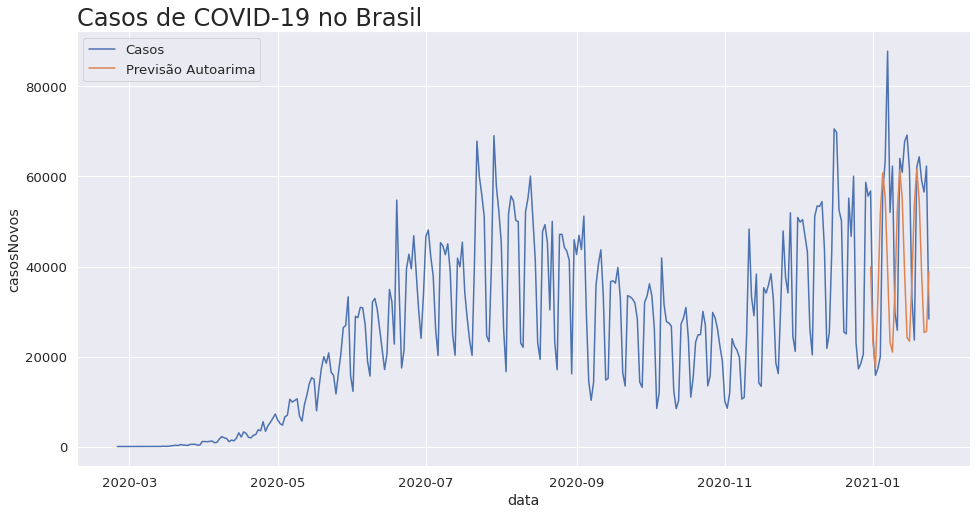

In [ ]:
sns.lineplot(x=covid_19_brasil.index, y='casosNovos', data=covid_19_brasil,
             label='Casos')
sns.lineplot(x=covid_19_brasil['2020-12-31':].index, y=previsao_auto_arima_casos[0],
             label='Previsão Autoarima')
plt.title('Casos de COVID-19 no Brasil', fontsize=24, loc='left');

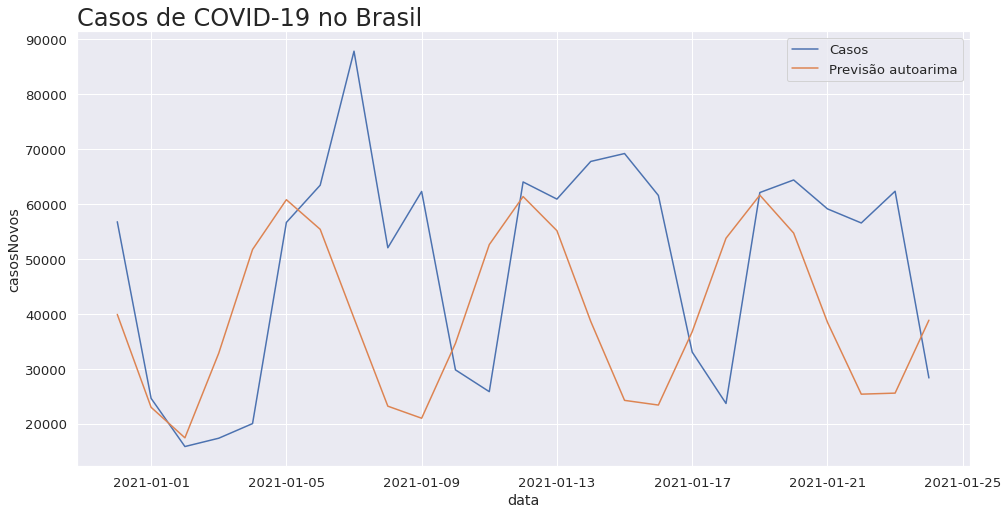

In [ ]:
sns.lineplot(x=covid_19_brasil['2020-12-31':].index, y='casosNovos', 
             data=covid_19_brasil['2020-12-31':], label='Casos')
sns.lineplot(x=covid_19_brasil['2020-12-31':].index, y=previsao_auto_arima_casos[0],
             label='Previsão autoarima')
plt.title('Casos de COVID-19 no Brasil', fontsize=24, loc='left');

In [ ]:
erro_modelo_arima_casos = mean_squared_error(covid_19_brasil_casos_teste, 
                   previsao_auto_arima_casos[0])
print(f'''
Erro médio quadrado do modelo: {erro_modelo_arima_casos:.2f}
''')


Erro médio quadrado do modelo: 620302694.12



Obteve se um erro muito alto.

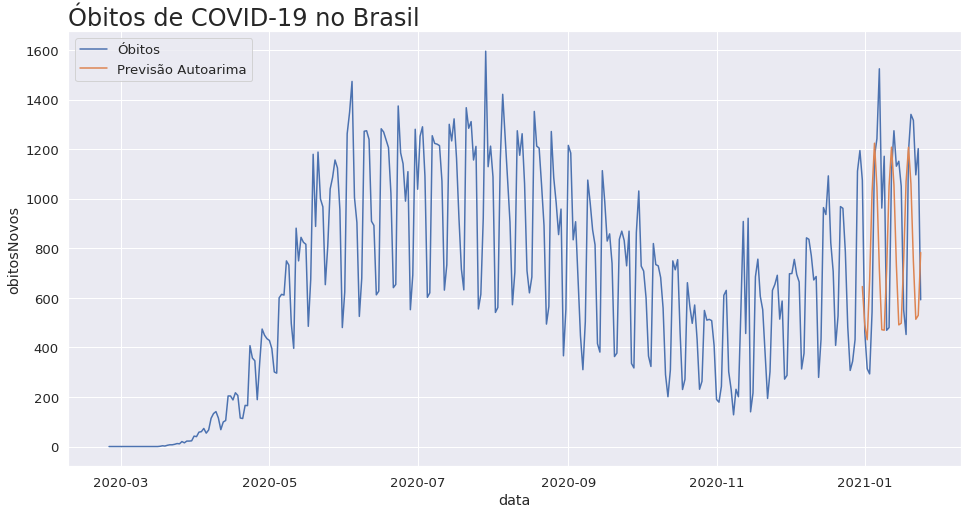

In [ ]:
sns.lineplot(x=covid_19_brasil.index, y='obitosNovos', data=covid_19_brasil,
             label='Óbitos')
sns.lineplot(x=covid_19_brasil['2020-12-31':].index, y=previsao_auto_arima_obitos[0],
             label='Previsão Autoarima')
plt.title('Óbitos de COVID-19 no Brasil', fontsize=24, loc='left');

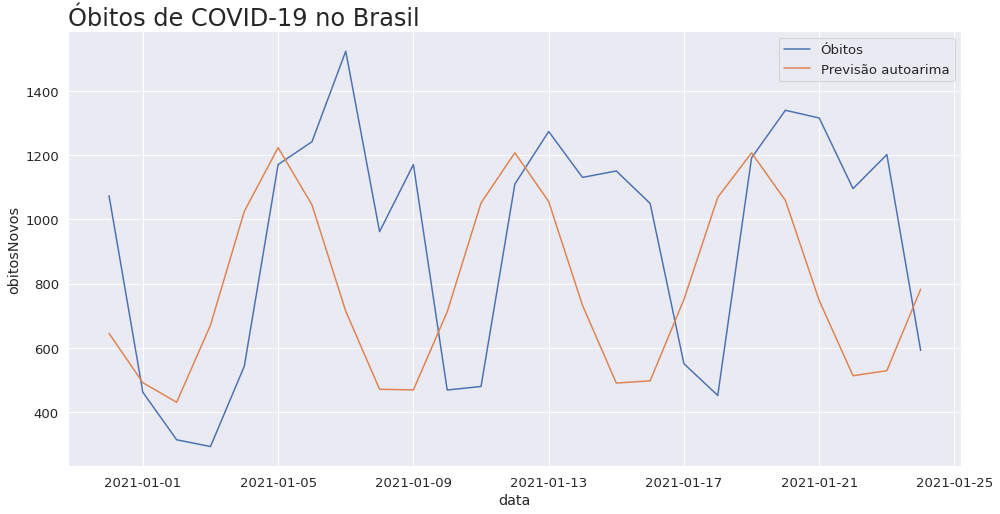

In [ ]:
sns.lineplot(x=covid_19_brasil['2020-12-31':].index, y='obitosNovos', 
             data=covid_19_brasil['2020-12-31':], label='Óbitos')
sns.lineplot(x=covid_19_brasil['2020-12-31':].index, y=previsao_auto_arima_obitos[0],
             label='Previsão autoarima')
plt.title('Óbitos de COVID-19 no Brasil', fontsize=24, loc='left');

In [ ]:
erro_modelo_arima_obitos = mean_squared_error(covid_19_brasil_obitos_teste, 
                   previsao_auto_arima_obitos[0])
print(f'''
Erro médio quadrado do modelo: {erro_modelo_arima_obitos:.2f}
''')


Erro médio quadrado do modelo: 199897.95



### 3.2.2 Modelo Prophet

In [ ]:
#Criando os dados de treino
covid_19_brasil_casos_treino_ph = pd.DataFrame(covid_19_brasil_casos_treino.copy().reset_index())
covid_19_brasil_obitos_treino_ph = pd.DataFrame(covid_19_brasil_obitos_treino.copy().reset_index())

In [ ]:
#Renomeando as colunas para o padrão utilizado pelo Prophet
covid_19_brasil_casos_treino_ph.rename({'data': 'ds', 'casosNovos': 'y'}, axis=1,
                                       inplace=True)
covid_19_brasil_obitos_treino_ph.rename({'data': 'ds', 'obitosNovos': 'y'}, axis=1,
                                        inplace=True)

In [ ]:
#Criando o modelo treinado do Prophet
modelo_prophet_casos = Prophet(seasonality_mode='multiplicative').fit(covid_19_brasil_casos_treino_ph)
modelo_prophet_obitos = Prophet(seasonality_mode='multiplicative').fit(covid_19_brasil_obitos_treino_ph)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#Criando o data frame de futuro do Prophet
casos_ph_futuro = modelo_prophet_casos.make_future_dataframe(24, 'D')
obitos_ph_futuro = modelo_prophet_obitos.make_future_dataframe(24, 'D')

In [ ]:
#Fazendo a previsão com base no modelo
previsao_prophet_casos = modelo_prophet_casos.predict(casos_ph_futuro)
previsao_prophet_obitos = modelo_prophet_obitos.predict(obitos_ph_futuro)

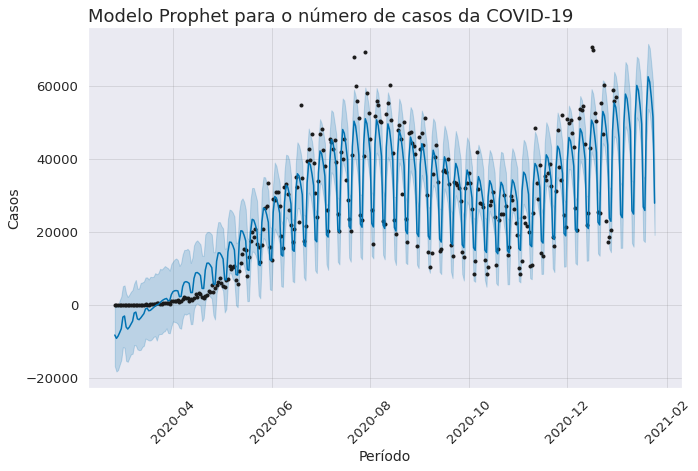

In [ ]:
modelo_prophet_casos.plot(previsao_prophet_casos)
plt.title('Modelo Prophet para o número de casos da COVID-19', fontsize=18,
          loc='left')
plt.xlabel('Período', fontsize=14)
plt.ylabel('Casos', fontsize=14)
plt.xticks(rotation=45);

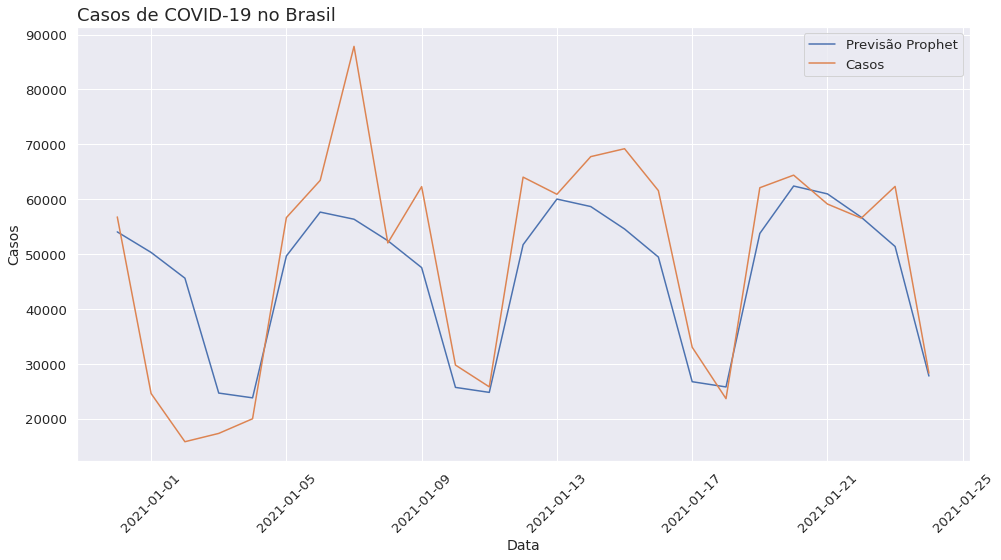

In [ ]:
sns.lineplot(x='ds', y='yhat', 
             data=previsao_prophet_casos[-len(covid_19_brasil_casos_teste):], 
             label='Previsão Prophet')
sns.lineplot(x=covid_19_brasil_casos_teste.index, y=covid_19_brasil_casos_teste,
             label='Casos')
personaliza_grafico_simples('Casos de COVID-19 no Brasil', 'Data', 'Casos')
plt.xticks(rotation=45);

In [ ]:
erro_modelo_prophet_casos = mean_squared_error(covid_19_brasil_casos_teste, 
                                         previsao_prophet_casos['yhat'][-len(covid_19_brasil_casos_teste):])
print(f'''
Erro médio quadrado: {erro_modelo_prophet_casos:.2f}
''')


Erro médio quadrado: 150763442.01



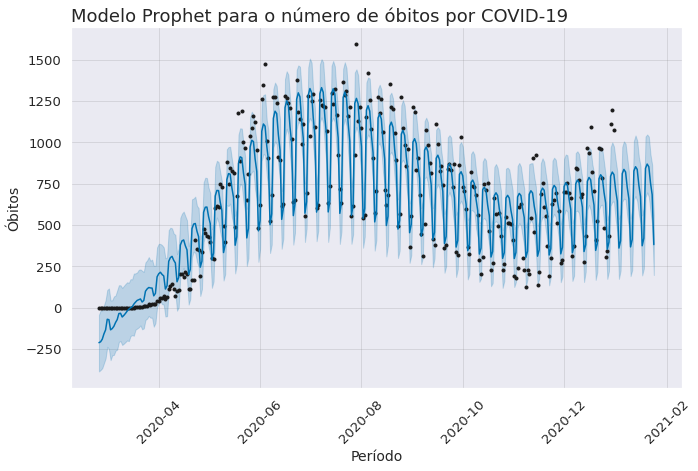

In [ ]:
modelo_prophet_obitos.plot(previsao_prophet_obitos)
plt.title('Modelo Prophet para o número de óbitos por COVID-19', fontsize=18,
          loc='left')
plt.xlabel('Período', fontsize=14)
plt.ylabel('Óbitos', fontsize=14)
plt.xticks(rotation=45);

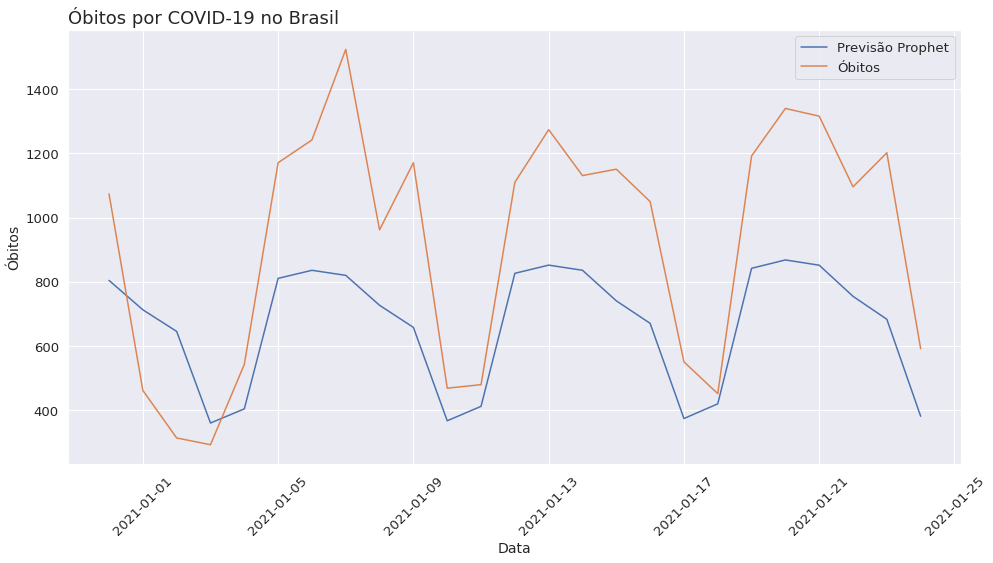

In [ ]:
sns.lineplot(x='ds', y='yhat', 
             data=previsao_prophet_obitos[-len(covid_19_brasil_casos_teste):], 
             label='Previsão Prophet')
sns.lineplot(x=covid_19_brasil_obitos_teste.index, y=covid_19_brasil_obitos_teste,
             label='Óbitos')
personaliza_grafico_simples('Óbitos por COVID-19 no Brasil', 'Data', 'Óbitos')
plt.xticks(rotation=45);

In [ ]:
erro_modelo_prophet_obitos = mean_squared_error(covid_19_brasil_obitos_teste, 
                                         previsao_prophet_obitos['yhat'][-len(covid_19_brasil_casos_teste):])
print(f'''
Erro médio quadrado: {erro_modelo_prophet_obitos:.2f}
''')


Erro médio quadrado: 122805.93



O modelo não se ajustou ao pico que ocorreu em janeiro de 2021.

O modelo Prophet retornou com menor erro comparado ao modelo Arima.

In [ ]:
print(f'''
Casos de COVID-19

Diferença do erro do modelo Arima - Prophet = {erro_modelo_arima_casos - 
                                               erro_modelo_prophet_casos:.2f}
''')


Casos de COVID-19

Diferença do erro do modelo Arima - Prophet = 469539252.11



In [ ]:
print(f'''
Óbitos por COVID-19

Diferença do erro do modelo Arima - Prophet = {erro_modelo_arima_obitos - 
                                               erro_modelo_prophet_obitos:.2f}
''')


Óbitos por COVID-19

Diferença do erro do modelo Arima - Prophet = 77092.03



### 3.2.3 Previsão para 14 dias com Prophet

Inicialmente será feita a previsão para o número de casos e óbitos por COVID-19 utilizando toda a série desse dados.

In [ ]:
#Cópia dos dados de interesse
covid_19_brasil_casos_prophet = covid_19_brasil[['casosNovos']].copy().reset_index()
covid_19_brasil_obitos_prophet = covid_19_brasil[['obitosNovos']].copy().reset_index()

In [ ]:
#Renomeando as colunas para o padrão utilizado pelo Prophet
covid_19_brasil_casos_prophet.rename({'data': 'ds', 'casosNovos': 'y'}, 
                                     axis=1, inplace=True)
covid_19_brasil_obitos_prophet.rename({'data': 'ds', 'obitosNovos': 'y'}, 
                                     axis=1, inplace=True)

In [ ]:
#Criando e treinando o modelo
modelo_prophet_casos_total = Prophet(seasonality_mode='multiplicative').fit(
    covid_19_brasil_casos_prophet
)
modelo_prophet_obitos_total = Prophet(seasonality_mode='multiplicative').fit(
    covid_19_brasil_obitos_prophet
)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#Criando o futuro para previsão
casos_ph_futuro = modelo_prophet_casos_total.make_future_dataframe(14, 'D')
obitos_ph_futuro = modelo_prophet_obitos_total.make_future_dataframe(14, 'D')

In [ ]:
#Fazendo a previsão com o modelo
previsao_prophet_casos = modelo_prophet_casos_total.predict(casos_ph_futuro)
previsao_prophet_obitos = modelo_prophet_obitos_total.predict(obitos_ph_futuro)

In [ ]:
_ = plot_components_plotly(modelo_prophet_casos_total, previsao_prophet_casos)
_.update_layout(title_text='Componentes do modelo de previsão do número de casos',
                title_font_size=18)

In [ ]:
_ = plot_plotly(modelo_prophet_casos_total, previsao_prophet_casos)
_.update_layout(title_text='Modelo de previsão dos casos da COVID-19',
                xaxis_title='Data', yaxis_title='Casos', font=dict(size=14))

O modelo não se ajustou a pico no número de casos ocorrido em janeiro de 2021.

In [ ]:
_ = plot_components_plotly(modelo_prophet_obitos_total, previsao_prophet_obitos)
_.update_layout(title_text='Componentes do modelo de previsão do número de óbitos',
                title_font_size=18)

In [ ]:
_ = plot_plotly(modelo_prophet_obitos_total, previsao_prophet_obitos)
_.update_layout(title_text='Modelo de previsão dos óbitos por COVID-19',
                xaxis_title='Data', yaxis_title='Óbitos', font=dict(size=14))

O modelo prevê um crescimento linear de casos e óbitos por COVID-19, para melhorar o modelo será necessário considerar a queda no número de casos que será provocada pela vacinação, requerendo uma análise multivariada, mas ainda não há informações consolidadas sobre distribuição e eficácia da vacinação.

# **4 Considerações Finais**

Para fins de previsão do número de casos e óbitos da COVID-19 no Brasil foi utilizado o modelo Autoarima e Prophet, sendo o último o que melhor se ajustou a série temporal da COVID-19, prevendo aumento no número de casos e óbitos para os próximo 14 dias, dada a tendência de crescimento iniciada em novembro de 2020. 
A previsão do número de casos e óbitos possibilitaria um planejamento prévio para ações de controle da pandemia e de acesso ao SUS, bem como ações de distanciamento social, mas para tal seria necessário o uso de outras variáveis (modelo multivariado) para aumentar a acurácia da previsão. 
Uma iniciativa que fornece informações preditivas é o site [COVID-19 Analytics](https://covid19analytics.com.br/) desenvolvido por professores da PUC Rio com o objetivo de fornecer apoio a decisão de curto prazo frete a pandemia.
Fica aqui como desafio a construção de um modelo multivariado que leve em consideração outras variáveis que impactam no número de casos e óbitos por COVID-19. 

# **5 Referências**

Coronavírus Brasil. Painel Coronavírus. Disponível em: https://covid.saude.gov.br/. Acesso em: 25 Jan. 2021.

MathWorks. Autocorrelation and Partial Autocorrelation. Disponível em: https://www.mathworks.com/help/econ/autocorrelation-and-partial-autocorrelation.html. Acesso em: 23 Jan. 2021.



---

